Day  1: Avg Price = 3.31
Day  2: Avg Price = 3.28
Day  3: Avg Price = 3.26
Day  4: Avg Price = 3.24
Day  5: Avg Price = 3.21
Day  6: Avg Price = 3.19
Day  7: Avg Price = 3.16
Day  8: Avg Price = 3.14
Day  9: Avg Price = 3.12
Day 10: Avg Price = 3.09
Day 11: Avg Price = 3.07
Day 12: Avg Price = 3.05
Day 13: Avg Price = 3.02
Day 14: Avg Price = 3.00
Day 15: Avg Price = 2.98
Day 16: Avg Price = 2.96
Day 17: Avg Price = 2.93
Day 18: Avg Price = 2.91
Day 19: Avg Price = 2.89
Day 20: Avg Price = 2.87
Day 21: Avg Price = 2.85
Day 22: Avg Price = 2.83
Day 23: Avg Price = 2.80
Day 24: Avg Price = 2.78
Day 25: Avg Price = 2.76
Day 26: Avg Price = 2.74
Day 27: Avg Price = 2.72
Day 28: Avg Price = 2.70
Day 29: Avg Price = 2.68
Day 30: Avg Price = 2.66
Day 31: Avg Price = 2.64
Day 32: Avg Price = 2.62
Day 33: Avg Price = 2.60
Day 34: Avg Price = 2.58
Day 35: Avg Price = 2.56
Day 36: Avg Price = 2.54
Day 37: Avg Price = 2.52
Day 38: Avg Price = 2.50
Day 39: Avg Price = 2.49
Day 40: Avg Price = 2.47


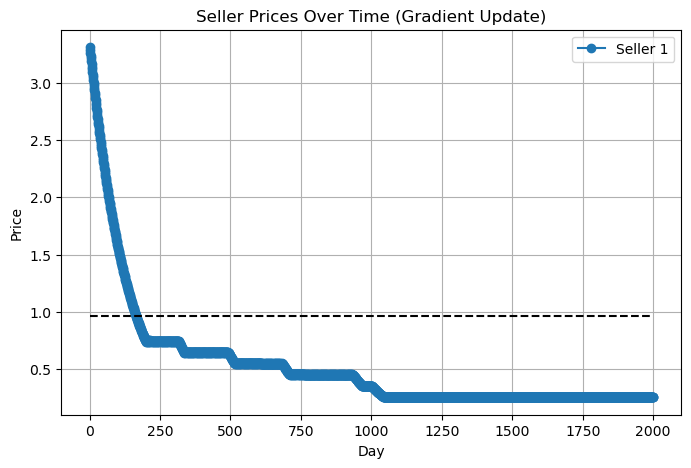

Max profits at price 0.6613226452905812


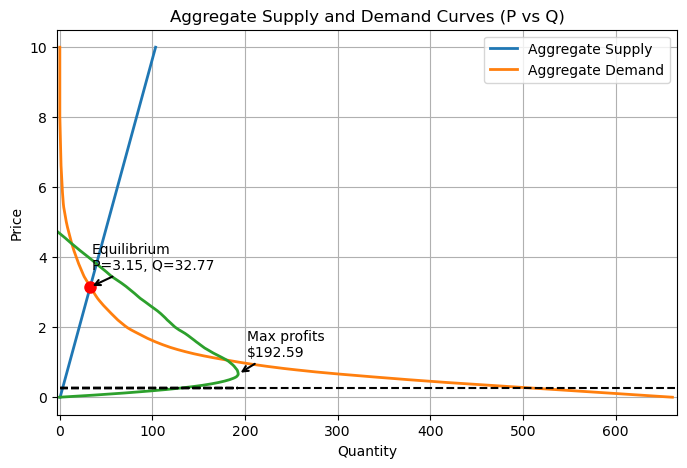

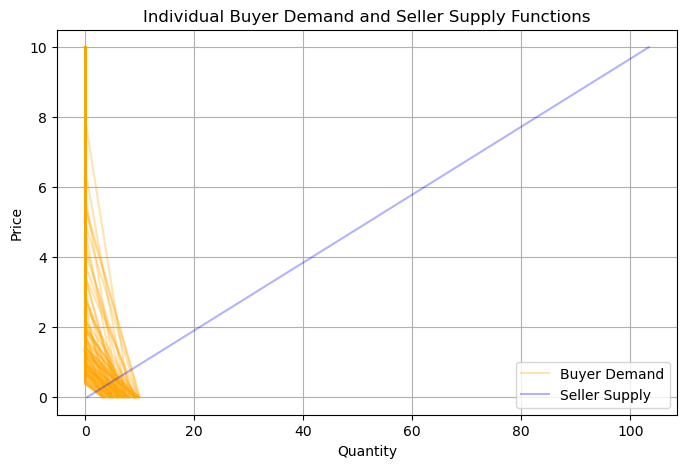

[0.2574215237865134, 0.25935218521491227, 0.2612973266040241, 0.25933759665449396, 0.25739256467958527]


In [103]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# Simulation Parameters
# ---------------------
num_sellers = 1       # Number of sellers
num_buyers  = 100        # Number of buyers
num_days    = 2000      # Number of days to simulate
num_interactions = 10000 # Daily buyer-seller interactions

delta = 0.0075         # Step size for price change

# ----------------------------
# Initialize Sellers and Buyers
# ----------------------------
np.random.seed(43)  # For reproducibility

# Sellers: each has a linear supply function: Q_s = c + d * price.
seller_c = np.random.uniform(0, 3, num_sellers)       # Supply intercepts
seller_d = np.random.uniform(10, 10.5, num_sellers)       # Supply slopes

# Start each seller at an initial price, e.g., 10.
# seller_prices = np.full(num_sellers, 10.0)
seller_prices = np.random.random(num_sellers) * 10 + 2
marginal_cost = np.random.uniform(0, 1, num_sellers) * 4

# Buyers: each has a linear demand function: Q_d = max(A - B * price, 0).
buyer_A = np.random.uniform(3, 10, num_buyers)         # Demand intercepts
buyer_B = np.random.uniform(1, 10, num_buyers)         # Demand slopes

def demand(price):
    if len(price.shape) >= 1:
        return np.maximum(buyer_A[:, None] - buyer_B[:, None] * price[None], 0)
    return np.maximum(buyer_A - buyer_B * price, 0)

def wtp(quantity, buyer_A, buyer_B):
    return buyer_A/buyer_B - quantity/buyer_B 

def supply(price, seller_c, seller_d):
    return seller_c + seller_d * price

# print("Seller Prices:", seller_prices)
# print("Demand", demand(seller_prices))
# print("Supply", supply(seller_prices))
# print("WTP", wtp(supply(seller_prices)))

# For tracking profit and update direction per seller:
prev_profit = np.zeros(num_sellers)     # Profit = price * units sold
price_direction = np.ones(num_sellers)  # +1 if last change was an increase, -1 for a decrease

# For recording simulation statistics:
avg_prices = []
# Save prices of all sellers each day (each element is a copy of seller_prices at that day)
all_seller_prices = []

# ---------------------
# Simulation Loop
# ---------------------
for day in range(num_days):
    # Each seller computes desired supply based on current price.
    # Sellers "bring" their supply as inventory:
    desired_supply = supply(seller_prices, seller_c, seller_d).copy()
    inventory = desired_supply.copy()
    sales = np.zeros(num_sellers) # quantity sold by each seller

    # Sort sellers by price (ascending).
    # sorted_sellers = np.argsort(seller_prices)
    
    # --- Market Interactions ---
    # For each interaction, choose a buyer at random.
    for interaction in range(num_interactions):
        buyer_idx = np.random.randint(0, num_buyers)

        # Identify sellers with available inventory.
        available = np.where(inventory > 0)[0]
        if available.size == 0:
            break  # No supply available.
        
        # Filter sellers where the buyer's willingness-to-pay is positive:
        candidate_mask = wtp(inventory[available], buyer_A[buyer_idx], buyer_B[buyer_idx]) >= seller_prices[available]
        candidates = available[candidate_mask]

        if candidates.size == 0:
            continue  # Buyer not willing to pay any available price.
        
        # Among candidates, select the seller with the lowest price.
        candidate_prices = seller_prices[candidates]
        min_price = candidate_prices.min()
        
        # Use an epsilon bound (0.1) to allow some randomness.
        epsilon = 0.0
        within_bound = candidates[candidate_prices <= (min_price + epsilon)]
        chosen = np.random.choice(within_bound)
        
        # Process the sale (one unit):
        inventory[chosen] -= 1
        sales[chosen] += 1
            
    # --- Price Update: Gradient-Ascent–like Rule ---
    # Compute current profit for each seller.
    current_profit = seller_prices * sales - marginal_cost * desired_supply

    new_prices = np.zeros_like(seller_prices)
    for i in range(num_sellers):
        if price_direction[i] > 0:  # Last move was an increase.
            if current_profit[i] > prev_profit[i]:
                # Increase again if profit improved.
                new_prices[i] = seller_prices[i] * (1 + delta)
                price_direction[i] = +1
            else:
                # Otherwise, reverse: decrease price.
                new_prices[i] = seller_prices[i] * (1 - delta)
                price_direction[i] = -1
        else:  # Last move was a decrease.
            if current_profit[i] > prev_profit[i]:
                # Continue to decrease if profit improved.
                new_prices[i] = seller_prices[i] * (1 - delta)
                price_direction[i] = -1
            else:
                # Otherwise, reverse: increase price.
                new_prices[i] = seller_prices[i] * (1 + delta)
                price_direction[i] = +1
        # Enforce a minimum price.
        new_prices[i] = max(new_prices[i], 0.1)
    
    seller_prices = new_prices.copy()
    avg_prices.append(np.mean(seller_prices))
    all_seller_prices.append(seller_prices.copy())  # Save the price vector for this day.
    prev_profit = current_profit.copy()
    print(f"Day {day+1:2d}: Avg Price = {np.mean(seller_prices):.2f}")

# ---------------------
# Plot 1: Seller Prices Over Time
# ---------------------
plt.figure(figsize=(8,5))
days = np.arange(1, num_days+1)
if num_sellers <= 5:
    for i in range(num_sellers):
        # Extract the price history for seller i.
        seller_history = [day_prices[i] for day_prices in all_seller_prices]
        plt.plot(days, seller_history, marker='o', label=f"Seller {i+1}")
else:
    for i in range(num_sellers):
        # Extract the price history for seller i.
        seller_history = [day_prices[i] for day_prices in all_seller_prices]
        plt.plot(days, seller_history, alpha=0.25)
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Seller Prices Over Time (Gradient Update)")
plt.grid(True)
plt.legend()
plt.hlines(marginal_cost, 0, num_days, color='k', linestyle='--')
plt.show()

# ---------------------
# Plot 2: Aggregate Supply and Demand Curves (P vs Q)
# ---------------------
p_values = np.linspace(0, 10, 500)
# Aggregate Supply: S(p) = sum(c_i + d_i * p)
agg_supply_curve = supply(p_values[None], seller_c[:, None], seller_d[:, None]).sum(0)
# Aggregate Demand: D(p) = sum(max(A_j - B_j * p, 0))
agg_demand_curve = demand(p_values).sum(0)

plt.figure(figsize=(8,5))
plt.plot(agg_supply_curve, p_values, label="Aggregate Supply", linewidth=2)
plt.plot(agg_demand_curve, p_values, label="Aggregate Demand", linewidth=2)
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Aggregate Supply and Demand Curves (P vs Q)")
plt.grid(True)
plt.xlim([-3, agg_demand_curve.max() + 5])
plt.legend()

# Mark approximate equilibrium (where curves are closest):
diff = np.abs(agg_supply_curve - agg_demand_curve)
idx_eq = np.argmin(diff)
p_eq = p_values[idx_eq]
Q_eq = agg_supply_curve[idx_eq]  # Approximately equal to agg_demand_curve[idx_eq]
plt.plot(Q_eq, p_eq, 'ro', markersize=8)

# Revenue comes from quantity demanded times the price set
# Cost comes from the quantity produced (supplied) times the marginal cost
profits = agg_demand_curve * p_values - marginal_cost * supply(p_values, seller_c, seller_d)
max_profit = profits.max()
max_profit_price = p_values[profits.argmax()]
profit_supply = supply(max_profit_price, seller_c, seller_d)[0]
plt.plot(profits, p_values, label="Profits", linewidth=2)
print("Max profits at price", p_values[profits.argmax()])
plt.annotate(f"Equilibrium\nP={p_eq:.2f}, Q={Q_eq:.2f}", 
             xy=(Q_eq, p_eq), xytext=(Q_eq + 0.05*Q_eq, p_eq + 0.5),
             arrowprops=dict(arrowstyle="->", lw=1.5))
plt.hlines(seller_prices, xmin=0, xmax=num_days, color='k', linestyle='--')
plt.hlines([p[0] for p in all_seller_prices[-10:]], xmin=0, xmax=profits.max(), color='k', linestyle='--')
plt.annotate(f"Max profits\n${max_profit:.2f}", 
             xy=(max_profit, max_profit_price), xytext=(max_profit + 0.05*max_profit, max_profit_price + 0.5),
             arrowprops=dict(arrowstyle="->", lw=1.5))
plt.show()

# ---------------------
# Plot 3: Individual Buyer Demand and Seller Supply Functions
# ---------------------
plt.figure(figsize=(8,5))
price_range = np.linspace(0, 10, 500)
# Plot each buyer's demand function in orange.
for i in range(num_buyers):
    q_d = np.maximum(buyer_A[i] - buyer_B[i] * price_range, 0)
    plt.plot(q_d, price_range, color='orange', alpha=0.3, 
             label="Buyer Demand" if i == 0 else "")
# Plot each seller's supply function in blue.
for i in range(num_sellers):
    q_s = seller_c[i] + seller_d[i] * price_range
    plt.plot(q_s, price_range, color='blue', alpha=0.3, 
             label="Seller Supply" if i == 0 else "")
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Individual Buyer Demand and Seller Supply Functions")
plt.legend()
plt.grid(True)
plt.show()

print(avg_prices[-5:])

In [106]:
print('Prices', seller_prices)
print("Marginal cost", marginal_cost)
print('Sales', sales)
print("total sales", np.sum(sales))
print('Profit', current_profit)
print('Supply', supply(seller_prices, seller_c, seller_d))
print('WTP', wtp(supply(seller_prices, seller_c, seller_d)[None], buyer_A[:, None], buyer_B[:, None])[:3])

Prices [0.25739256]
Marginal cost [0.96235848]
Sales [4.]
total sales 4.0
Profit [-1.86658229]
Supply [2.99747395]
WTP [[0.29510737]
 [0.80872305]
 [0.4924175 ]]


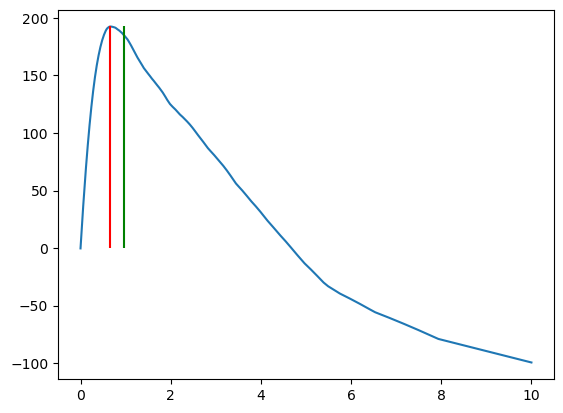

In [105]:
plt.plot(p_values, profits)
plt.vlines(p_values[profits.argmax()], ymin=0, ymax=profits.max(), color='r')
plt.vlines(marginal_cost, 0, profits.max(), color='g')